
# Experiment 3 — LoRA Adapters + Bayesian Approximation (Laplace/Fisher) for 3‑way MCQ

**Goal.** Start from a small pretrained text encoder, add **LoRA adapters** to a few attention/projection modules, fine‑tune only those adapters on a **3‑option multiple‑choice** task, then place a **Bayesian posterior** over the *adapter parameters* using a simple **diagonal Laplace / Fisher approximation**.

**Why this is nice (for education + speed):**
- We avoid sampling full Transformer weights. We only adapt a tiny set of parameters (LoRA).
- After fine‑tuning, we build a Gaussian posterior around the MAP solution using the **empirical Fisher diagonal** (i.e., squared gradients under the data).
- Posterior predictive = **Monte Carlo average** over a few draws of adapter weights.
- We can then plot the same **calibration** and **abstention** figures as in the previous experiments.



## 0) Setup

Install (inside your Pipenv or environment):
```bash
pipenv run pip install "torch>=2.2" transformers peft accelerate datasets     scikit-learn pandas matplotlib numpy tqdm
```
> On Apple Silicon without GPU, this runs on CPU and is fine for small models.



## Model — Encoder + LoRA adapters

We use a small encoder to keep it fast. We score each (question, option) pair separately, then **softmax across the options**.


In [285]:

import torch
from torch import nn
from transformers import AutoTokenizer, AutoModel, AutoModelForMultipleChoice
from peft import LoraConfig, get_peft_model, TaskType
import re

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

#model_name = "prajjwal1/bert-tiny"  # small & fast
#model_name = "microsoft/MiniLM-L12-H384-uncased"
# model_name = "prajjwal1/bert-small"
model_name = "bert-base-uncased"
#model_name = "distilbert-base-uncased"

tok = AutoTokenizer.from_pretrained(model_name)

# Multiple-choice model (has a classification head that returns logits per choice)
base_mc = AutoModelForMultipleChoice.from_pretrained(model_name).to(device)

target_modules = {
    'bert-base-uncased': ["query", "key", "value", "dense"],
    'distilbert-base-uncased': ["q_lin", "k_lin", "v_lin", "out_lin"]
}
layers_to_transform = {
    'bert-base-uncased': [10, 11],
    'distilbert-base-uncased': [4, 5],
}
layers_pattern = {
    'bert-base-uncased': "encoder.layer",
    'distilbert-base-uncased': "transformer.layer",
}

# LoRA for sequence classification (MC is a seq-classification task)
lora_cfg = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=target_modules[model_name],
    layers_to_transform=layers_to_transform[model_name],
    layers_pattern=layers_pattern[model_name],  # prefix before the {index}
    bias="none",
)
model = get_peft_model(base_mc, lora_cfg).to(device)

# Optimizer
opt = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)



Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



## 4) Dataloaders — turn MCQ into pairwise inputs

Each example yields 3 encodings: (question, option_a/b/c) → we get [CLS] and score each separately.


In [286]:
# ==== Load CommonsenseQA and build DataLoaders (N-choice) ====

# pip install -q datasets  # run once if you don't have it
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import random

# Reproducibility
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# 1) Load the dataset (train/validation/test)
csqa = load_dataset("commonsense_qa")
print(csqa)  # shows split sizes


class CommonsenseQADataset(Dataset):
    def __init__(self, hf_split):
        self.data = hf_split
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        ex = self.data[idx]
        q = ex["question"]
        opts = ex["choices"]["text"]           # list of 5 options
        labs = ex["choices"]["label"]          # ['A','B','C','D','E']
        y = labs.index(ex["answerKey"])
        return q, opts, y


class CSQA3ChoiceDataset(Dataset):
    def __init__(self, hf_split, seed=42, per_epoch=False):
        self.data = hf_split
        self.seed = seed
        self.per_epoch = per_epoch
        self._rng = np.random.default_rng(seed)
        self._indices = self._make_indices()

    def _make_indices(self):
        idxs = []
        for ex in self.data:
            labels = ex["choices"]["label"]          # ['A','B','C','D','E']
            texts  = ex["choices"]["text"]
            correct_idx = labels.index(ex["answerKey"])
            wrong_pool = [i for i in range(len(texts)) if i != correct_idx]
            chosen_wrongs = self._rng.choice(wrong_pool, size=2, replace=False).tolist()
            picked = [correct_idx] + chosen_wrongs
            self._rng.shuffle(picked)
            new_gold = picked.index(correct_idx)
            idxs.append((picked, new_gold))
        return idxs

    def reshuffle(self):
        self._rng = np.random.default_rng(self.seed + 1 + self._rng.integers(1_000_000))
        self._indices = self._make_indices()

    def __len__(self): return len(self.data)

    def __getitem__(self, i):
        ex = self.data[i]
        picked, new_gold = self._indices[i]
        opts3 = [ex["choices"]["text"][j] for j in picked]
        return ex["question"], opts3, int(new_gold)


def collate(batch, max_length=96):
    qs, opts_list, labels = zip(*batch)
    encs = []
    for q, opts in zip(qs, opts_list):
        enc = tok([q]*len(opts), list(opts),
                  truncation=True, padding="max_length",
                  max_length=max_length, return_tensors="pt")
        encs.append(enc)
    out = {
        "input_ids":      torch.stack([e["input_ids"] for e in encs], dim=0),
        "attention_mask": torch.stack([e["attention_mask"] for e in encs], dim=0),
        "labels":         torch.tensor(labels, dtype=torch.long),
    }
    return {k: v.to(model.device) for k, v in out.items()}

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'question_concept', 'choices', 'answerKey'],
        num_rows: 9741
    })
    validation: Dataset({
        features: ['id', 'question', 'question_concept', 'choices', 'answerKey'],
        num_rows: 1221
    })
    test: Dataset({
        features: ['id', 'question', 'question_concept', 'choices', 'answerKey'],
        num_rows: 1140
    })
})


In [287]:
from datasets import load_dataset

csqa = load_dataset("commonsense_qa")

# take the first n examples after a shuffle
N_TRAIN = 5000
N_VAL   = 1000

train_split = csqa["train"].shuffle(seed=42).select(range(N_TRAIN))
val_split   = csqa["validation"].shuffle(seed=42).select(range(N_VAL))

train_ds = CSQA3ChoiceDataset(train_split)
val_ds   = CSQA3ChoiceDataset(val_split)  # use as test/val

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  collate_fn=collate)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, collate_fn=collate)

# Sanity check
batch = next(iter(train_loader))
print("Batch shapes:", {k: tuple(v.shape) for k, v in batch.items()})
# Expect: {'input_ids': (B, 3, T), 'attention_mask': (B, 3, T), 'labels': (B,)}


Batch shapes: {'input_ids': (16, 3, 96), 'attention_mask': (16, 3, 96), 'labels': (16,)}



## 5) Fine‑tune LoRA adapters (MAP estimate)

We optimize only **LoRA adapter params** and the **linear head**, with cross‑entropy over the 3 options.


In [288]:
from tqdm import tqdm
from torch.cuda.amp import autocast  # yes, name says cuda; works with device_type='mps' in PyTorch 2.x

EPOCHS = 20
best = {"acc": 0.0, "state": None}
for ep in range(1, EPOCHS+1):
    # train
    model.train()
    tot, correct, loss_sum = 0, 0, 0.0
    for batch in tqdm(train_loader, desc=f"ep {ep} [train]"):
        opt.zero_grad(set_to_none=True)
        with torch.autocast(device_type="mps", dtype=torch.float16):
            out  = model(**batch)     # for MC models: returns loss + logits
            loss = out.loss
        loss.backward()
        opt.step()
        
        loss_sum += loss.item() * batch["labels"].size(0)
        pred = out.logits.argmax(dim=1)
        correct += (pred == batch["labels"]).sum().item()
        tot += batch["labels"].size(0)
    tr_loss = loss_sum / max(tot, 1)
    tr_acc  = correct / max(tot, 1)

    # eval
    model.eval()
    tot, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"ep {ep} [eval]"):
            out = model(**batch)
            loss_sum += out.loss.item() * batch["labels"].size(0)
            pred = out.logits.argmax(dim=1)
            correct += (pred == batch["labels"]).sum().item()
            tot += batch["labels"].size(0)
    te_loss = loss_sum / max(tot, 1)
    te_acc  = correct / max(tot, 1)
    print(f"epoch {ep:02d} | train loss {tr_loss:.3f} acc {tr_acc:.3f} | val loss {te_loss:.3f} acc {te_acc:.3f}")
    
    if te_acc > best["acc"] + 1e-3:
        best["acc"] = te_acc
        best["state"] = {"model": model.state_dict()}
model.load_state_dict(best["state"]["model"])

ep 1 [eval]: 100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


epoch 01 | train loss 1.099 acc 0.344 | val loss 1.091 acc 0.394


ep 2 [eval]: 100%|██████████| 32/32 [00:21<00:00,  1.47it/s]


epoch 02 | train loss 1.090 acc 0.383 | val loss 1.075 acc 0.439


ep 3 [eval]: 100%|██████████| 32/32 [00:21<00:00,  1.47it/s]


epoch 03 | train loss 1.082 acc 0.391 | val loss 1.048 acc 0.501


ep 4 [eval]: 100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


epoch 04 | train loss 1.063 acc 0.439 | val loss 1.017 acc 0.517


ep 5 [eval]: 100%|██████████| 32/32 [00:21<00:00,  1.48it/s]


epoch 05 | train loss 1.046 acc 0.448 | val loss 0.990 acc 0.537


ep 6 [eval]: 100%|██████████| 32/32 [00:21<00:00,  1.48it/s]


epoch 06 | train loss 1.028 acc 0.470 | val loss 0.967 acc 0.552


ep 7 [eval]: 100%|██████████| 32/32 [00:21<00:00,  1.48it/s]


epoch 07 | train loss 1.011 acc 0.493 | val loss 0.951 acc 0.554


ep 8 [eval]: 100%|██████████| 32/32 [00:21<00:00,  1.47it/s]


epoch 08 | train loss 1.005 acc 0.498 | val loss 0.944 acc 0.553


ep 9 [eval]: 100%|██████████| 32/32 [00:21<00:00,  1.47it/s]


epoch 09 | train loss 0.993 acc 0.504 | val loss 0.932 acc 0.557


ep 10 [eval]: 100%|██████████| 32/32 [00:21<00:00,  1.47it/s]


epoch 10 | train loss 0.977 acc 0.525 | val loss 0.925 acc 0.569


ep 11 [eval]: 100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


epoch 11 | train loss 0.970 acc 0.526 | val loss 0.918 acc 0.574


ep 12 [eval]: 100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


epoch 12 | train loss 0.964 acc 0.533 | val loss 0.914 acc 0.570


ep 13 [eval]: 100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


epoch 13 | train loss 0.968 acc 0.522 | val loss 0.911 acc 0.581


ep 14 [eval]: 100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


epoch 14 | train loss 0.952 acc 0.543 | val loss 0.906 acc 0.575


ep 15 [eval]: 100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


epoch 15 | train loss 0.945 acc 0.545 | val loss 0.899 acc 0.580


ep 16 [eval]: 100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


epoch 16 | train loss 0.951 acc 0.548 | val loss 0.898 acc 0.583


ep 17 [eval]: 100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


epoch 17 | train loss 0.945 acc 0.542 | val loss 0.895 acc 0.585


ep 18 [eval]: 100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


epoch 18 | train loss 0.950 acc 0.544 | val loss 0.893 acc 0.588


ep 19 [eval]: 100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


epoch 19 | train loss 0.948 acc 0.537 | val loss 0.893 acc 0.584


ep 20 [eval]: 100%|██████████| 32/32 [00:21<00:00,  1.46it/s]

epoch 20 | train loss 0.921 acc 0.566 | val loss 0.887 acc 0.587


<All keys matched successfully>


## 6) Diagonal Laplace / Empirical Fisher over LoRA + head

We approximate the posterior around the MAP θ with a **diagonal Gaussian**.  
For a batch, we accumulate the **squared gradients of log‑likelihood** (equivalently, gradients of CE) as the **empirical Fisher diagonal**.


In [289]:
# ==== Laplace snapshot utilities (PEFT-wrapped Multiple-Choice model) ====

import torch
import numpy as np
from tqdm import tqdm, trange

device = next(model.parameters()).device  # infer device from model

def get_trainable_snapshot():
    """Capture the CURRENT set of trainable params (LoRA + classifier head)."""
    params = [p for p in model.parameters() if p.requires_grad]
    shapes = [p.shape for p in params]
    numel  = sum(p.numel() for p in params)
    return params, shapes, numel

trainable, shapes, numel = get_trainable_snapshot()

def pack(params):
    return torch.cat([p.detach().reshape(-1) for p in params]).to(device)

def pack_grads(params):
    parts = []
    for p in params:
        if p.grad is None:
            parts.append(torch.zeros_like(p).reshape(-1))
        else:
            parts.append(p.grad.detach().reshape(-1))
    return torch.cat(parts).to(device)

def unpack(vec):
    out = []
    i = 0
    for shp in shapes:
        n = int(torch.tensor(shp).prod().item())
        out.append(vec[i:i+n].view(shp).clone())
        i += n
    return out

@torch.no_grad()
def set_params_from_vector(vec):
    """Write a flat vector back into the CURRENT trainable params (same ordering as snapshot)."""
    parts = unpack(vec)
    i = 0
    for p in model.parameters():
        if p.requires_grad:
            p.copy_(parts[i]); i += 1

theta_map = pack(trainable)  # MAP point (post-training weights)
print(f"[Laplace] trainable tensors: {len(trainable)} | numel: {numel:,}")

[Laplace] trainable tensors: 26 | numel: 221,953


In [294]:
# ==== Head-only Laplace: snapshot & helpers ====
import torch, numpy as np
from tqdm import tqdm, trange

device = next(model.parameters()).device

# Collect only head params (works for BERT/DistilBERT MC heads)
HEAD_KEYS = ("pre_classifier", "classifier")

def get_head_params():
    params, names = [], []
    for n, p in model.named_parameters():
        if p.requires_grad and any(k in n for k in HEAD_KEYS):
            params.append(p)
            names.append(n)
    if not params:
        raise RuntimeError("No head params found. Check HEAD_KEYS for your model.")
    return params, names

head_params, head_names = get_head_params()
head_shapes = [p.shape for p in head_params]
head_numel  = sum(p.numel() for p in head_params)

def pack_head():
    return torch.cat([p.detach().reshape(-1) for p in head_params]).to(device)

def pack_head_grads():
    parts = []
    for p in head_params:
        g = torch.zeros_like(p) if p.grad is None else p.grad.detach()
        parts.append(g.reshape(-1))
    return torch.cat(parts).to(device)

def unpack_head(vec):
    out, i = [], 0
    for shp in head_shapes:
        n = int(torch.tensor(shp).prod())
        out.append(vec[i:i+n].view(shp).clone()); i += n
    return out

@torch.no_grad()
def set_head_from_vector(vec):
    parts = unpack_head(vec); i = 0
    for p in head_params:
        p.copy_(parts[i]); i += 1

theta_head_map = pack_head()
print(f"[Head-Laplace] head tensors: {len(head_params)} | numel: {head_numel:,}")

[Head-Laplace] head tensors: 2 | numel: 769


In [300]:
# ==== Fisher diagonal over head only ====
from tqdm import tqdm

def fisher_diag_head(loader, num_batches=None, use_train_mode=False):
    model.train() if use_train_mode else model.eval()
    F = torch.zeros(head_numel, device=device)
    seen = 0

    for b, batch in enumerate(tqdm(loader, desc="Fisher (head)", leave=False)):
        if num_batches is not None and b >= num_batches:
            break
        model.zero_grad(set_to_none=True)
        out = model(**batch)                # CE averaged over batch
        bs = batch["labels"].shape[0]
        (out.loss * bs).backward()          # <-- scale by batch size (sum)
        F += pack_head_grads().pow(2)
        seen += bs

    return F + 1e-8   # diagonal approx, no division here

F_head = fisher_diag_head(train_loader, num_batches=300, use_train_mode=False)
print("F_head mean:", F_head.mean().item())

F_head mean: 115.07616424560547


Full Fisher treatment, optional

In [290]:
# ==== Empirical Fisher diagonal for Multiple-Choice model ====

import torch.nn as nn

def fisher_diag(train_loader, num_batches=300, use_train_mode=False, show_progress=True):
    """
    Empirical Fisher diagonal: E[(∂/∂θ log p(y|x,θ))^2] estimated by squared grads of CE loss.
    Uses the model's built-in MC loss (so pass labels in the batch).
    """
    # Mode (dropout behavior)
    if use_train_mode:
        model.train()
    else:
        model.eval()

    F = torch.zeros(numel, device=device)
    count = 0

    it = enumerate(train_loader)
    if show_progress:
        it = tqdm(it, total=None if num_batches is None else num_batches, desc="Fisher", leave=False)

    for b, batch in it:
        if num_batches and b >= num_batches:
            break

        # Ensure the batch has labels; model handles loss internally
        batch = {k: v for k, v in batch.items()}  # shallow copy
        model.zero_grad(set_to_none=True)

        out = model(**batch)         # expects labels; returns .loss
        loss = out.loss
        loss.backward()

        g = pack_grads(trainable)    # grads for CURRENT trainable set
        if g.numel() != numel:
            raise RuntimeError(f"Grad vector {g.numel()} != numel snapshot {numel}. Rebuild snapshot.")
        F += g.pow(2)
        count += 1

    if count > 0:
        F /= count
    return F + 1e-8  # jitter

# Compute F on your (sub)set
F_diag = fisher_diag(train_loader, num_batches=300, use_train_mode=False, show_progress=True)
print("F_diag:", tuple(F_diag.shape), "mean:", F_diag.mean().item())

F_diag: (221953,) mean: 3.953023042413406e-05



## 7) Posterior predictive via Gaussian samples over θ

We assume a **Gaussian posterior**: \( \theta \sim \mathcal{N}(\theta_{MAP}, \Sigma) \)  
with diagonal \( \Sigma = (\lambda \cdot F)^{-1} \). Hyper‑parameter \(\lambda\) acts like precision from a simple Gaussian prior / damping.


### Head only

In [305]:
# ==== Posterior predictive (head only) ====
from tqdm import tqdm, trange

@torch.no_grad()
def predict_proba_mc_head(loader, S=30, lam=100.0, show_progress=True):
    # lam is prior precision (weight-decay-like). Start with 100–1000.
    model.eval()
    precision = F_head + lam              # diagonal precision
    std = (1.0 / precision).sqrt()        # diag posterior std
    theta0 = pack_head()

    logits_samples = []
    outer = trange(S, desc="MC θ(head)", leave=show_progress, disable=not show_progress)
    for _ in outer:
        theta_s = theta_head_map + torch.randn_like(std) * std
        set_head_from_vector(theta_s)
        batch_logits = []
        inner = tqdm(loader, desc="batches", leave=False, disable=not show_progress)
        for batch in inner:
            b = {k:v for k,v in batch.items() if k!="labels"}
            batch_logits.append(model(**b).logits.detach().cpu())
        logits_samples.append(torch.cat(batch_logits, dim=0))

    set_head_from_vector(theta0)
    L = torch.stack(logits_samples, dim=0)        # (S,N,C)
    P = torch.softmax(L.mean(dim=0), dim=1)       # logit averaging
    return P.numpy()

In [306]:
# Deterministic MAP predictions
@torch.no_grad()
def predict_map(loader):
    model.eval()
    ps = []
    for batch in loader:
        b = {k: v for k, v in batch.items() if k != "labels"}
        ps.append(torch.softmax(model(**b).logits, dim=1).detach().cpu().numpy())
    return np.concatenate(ps, axis=0)

@torch.no_grad()
def collect_labels(loader):
    ys = []
    for batch in loader:
        ys.append(batch["labels"].cpu().numpy())
    return np.concatenate(ys, axis=0)

y_te = collect_labels(val_loader)
p_te_map = predict_map(val_loader)
p_te_lap = predict_proba_mc_head(val_loader, S=30, lam=100.0, show_progress=True)

acc_map = (p_te_map.argmax(1) == y_te).mean()
acc_lap = (p_te_lap.argmax(1) == y_te).mean()
print(f"MAP acc: {acc_map:.3f} | Laplace(head) acc: {acc_lap:.3f}")

MC θ(head): 100%|██████████| 30/30 [11:02<00:00, 22.07s/it]


MAP acc: 0.566 | Laplace(head) acc: 0.583


### Full treatment

In [291]:
# ==== Monte Carlo posterior predictive over choices (N-choice) ====

@torch.no_grad()
def predict_proba_mc(loader, S=30, lam=1.0, show_progress=True):
    """
    Returns mean probs over S parameter samples: shape (N_total_items, C).
    Assumes each batch has consistent C (true for CSQA).
    lam is the strength of the Gaussian prior in the Laplace approximation.
    """
    model.eval()

    assert F_diag.numel() == numel, f"F_diag {F_diag.numel()} != numel {numel}. Rebuild snapshot."
    var = 1.0 / (lam * F_diag)     # (numel,)
    std = var.sqrt()
    theta0 = pack(trainable)       # cache current params

    all_probs = []
    outer = trange(S, desc="MC θ samples", leave=False, disable=not show_progress)
    for _ in outer:
        theta_s = theta_map + torch.randn_like(std) * std
        set_params_from_vector(theta_s)

        batch_probs = []
        inner = loader if not show_progress else tqdm(loader, desc="MC batches", leave=False)
        for batch in inner:
            batch_nolabels = {k: v for k, v in batch.items() if k != "labels"}  # no labels at predict time
            out = model(**batch_nolabels)   # logits: (B, C)
            p = torch.softmax(out.logits, dim=1)  # (B, C)
            batch_probs.append(p.detach().cpu())
        all_probs.append(torch.cat(batch_probs, dim=0))

    # Restore original params
    set_params_from_vector(theta0)

    P = torch.stack(all_probs, dim=0).mean(dim=0).cpu().numpy()  # (N_total, C)
    return P

In [292]:
# ==== Example usage: MC posterior predictive on train/val ====

S_MC = 10 # 10: quick run
LAM  = 5.0 # Pure Fisher: 1.0

p_tr = predict_proba_mc(train_loader, S=S_MC, lam=LAM, show_progress=True)
p_te = predict_proba_mc(val_loader,   S=S_MC, lam=LAM, show_progress=True)
print("Shapes -> p_tr:", p_tr.shape, "p_te:", p_te.shape)

# Collect labels back from loaders (same order)
@torch.no_grad()
def collect_labels(loader):
    ys = []
    for batch in loader:
        ys.append(batch["labels"].detach().cpu().numpy())
    return np.concatenate(ys, axis=0)

y_tr = collect_labels(train_loader).astype(int)
y_te = collect_labels(val_loader).astype(int)

def accuracy_from_probs(p, y):
    return float((p.argmax(axis=1) == y).mean())

print(f"Acc train: {accuracy_from_probs(p_tr, y_tr):.3f} | val: {accuracy_from_probs(p_te, y_te):.3f}")

Shapes -> p_tr: (5000, 3) p_te: (1000, 3)
Acc train: 0.331 | val: 0.334



## 8) Metrics: Accuracy, Reliability Diagram, Selective Prediction


In [307]:
import numpy as np

def brier(p, y):
    Y = np.eye(p.shape[1])[y]
    return np.mean((p - Y)**2)

def reliability_quantile(p, y, n_bins=10):
    conf = p.max(1); pred = p.argmax(1); corr = (pred==y).astype(float)
    order = np.argsort(conf); conf = conf[order]; corr = corr[order]
    bins = np.array_split(np.arange(len(conf)), n_bins)
    ece = 0.0; pts = []
    for idx in bins:
        if len(idx)==0: continue
        c = conf[idx].mean(); a = corr[idx].mean()
        ece += (len(idx)/len(conf))*abs(a-c)
        pts.append((c,a,len(idx)))
    return np.array(pts), ece

# assuming you have:
# p_te_map, p_te_lap, y_te
acc_map = (p_te_map.argmax(1)==y_te).mean()
acc_lap = (p_te_lap.argmax(1)==y_te).mean()
brier_map = brier(p_te_map, y_te); brier_lap = brier(p_te_lap, y_te)
pts_map, ece_map = reliability_quantile(p_te_map, y_te, n_bins=10)
pts_lap, ece_lap = reliability_quantile(p_te_lap, y_te, n_bins=10)
print(f"ACC  MAP={acc_map:.3f}  Laplace={acc_lap:.3f}")
print(f"Brier MAP={brier_map:.4f} Laplace={brier_lap:.4f}")
print(f"  ECE MAP={ece_map:.4f}  Laplace={ece_lap:.4f}")

ACC  MAP=0.566  Laplace=0.583
Brier MAP=0.1800 Laplace=0.1774
  ECE MAP=0.0329  Laplace=0.0375


ACC   MAP=0.566  Laplace(head)=0.583
Brier MAP=0.1800 Laplace(head)=0.1774
ECE   MAP=0.0278  Laplace(head)=0.0411


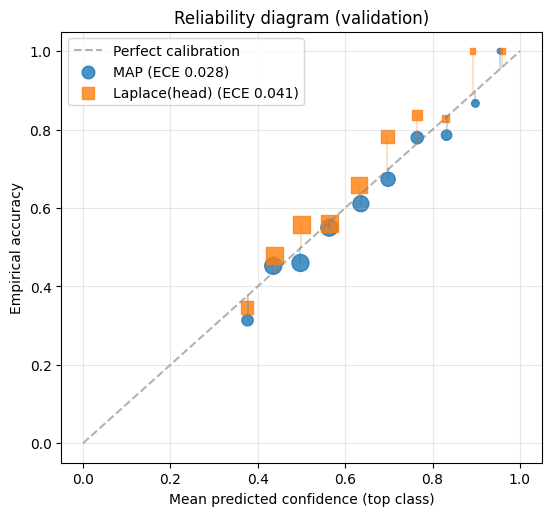

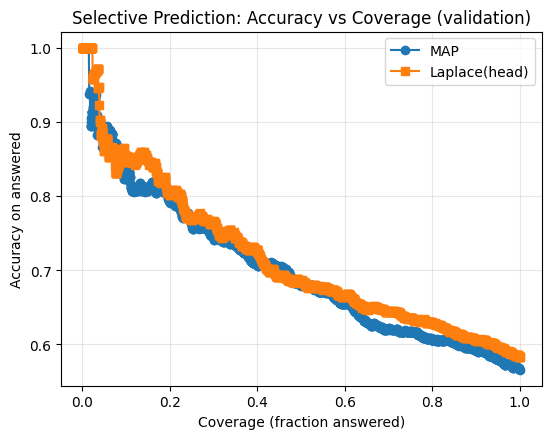

In [308]:
# ==== Accuracy, Reliability, and Selective Prediction: MAP vs Head-Laplace ====

import numpy as np
import matplotlib.pyplot as plt

# --- helpers ---
def brier(p, y):
    Y = np.eye(p.shape[1])[y]
    return np.mean((p - Y)**2)

def reliability_points_equalwidth(p, y, n_bins=15):
    conf = p.max(axis=1)
    pred = p.argmax(axis=1)
    correct = (pred == y).astype(np.float32)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    mids, accs, confs, counts = [], [], [], []
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        sel = (conf >= lo) & ((conf < hi) if i < n_bins-1 else (conf <= hi))
        if sel.any():
            mids.append(0.5*(lo+hi))
            accs.append(correct[sel].mean())
            confs.append(conf[sel].mean())
            counts.append(sel.sum())
    return np.array(mids), np.array(accs), np.array(confs), np.array(counts)

def expected_calibration_error(p, y, n_bins=15):
    conf = p.max(axis=1)
    pred = p.argmax(axis=1)
    correct = (pred == y).astype(np.float32)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    N = len(y)
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        sel = (conf >= lo) & ((conf < hi) if i < n_bins-1 else (conf <= hi))
        if sel.any():
            gap = abs(correct[sel].mean() - conf[sel].mean())
            ece += (sel.sum()/N) * gap
    return float(ece)

def evaluate_with_abstention(probs, y_true, tau=0.5):
    conf = probs.max(axis=1)
    pred = probs.argmax(axis=1)
    answered = conf >= tau
    coverage = answered.mean()
    acc = float("nan") if coverage == 0 else (pred[answered] == y_true[answered]).mean()
    return coverage, acc

# --- metrics (print) ---
acc_map = (p_te_map.argmax(1) == y_te).mean()
acc_lap = (p_te_lap.argmax(1) == y_te).mean()
brier_map = brier(p_te_map, y_te)
brier_lap = brier(p_te_lap, y_te)
ece_map = expected_calibration_error(p_te_map, y_te, n_bins=15)
ece_lap = expected_calibration_error(p_te_lap, y_te, n_bins=15)
print(f"ACC   MAP={acc_map:.3f}  Laplace(head)={acc_lap:.3f}")
print(f"Brier MAP={brier_map:.4f} Laplace(head)={brier_lap:.4f}")
print(f"ECE   MAP={ece_map:.4f}  Laplace(head)={ece_lap:.4f}")

# --- Reliability diagram (equal-width bins) ---
m_m, a_m, c_m, n_m = reliability_points_equalwidth(p_te_map, y_te, n_bins=15)
m_l, a_l, c_l, n_l = reliability_points_equalwidth(p_te_lap, y_te, n_bins=15)

plt.figure(figsize=(6.2,5.6))
plt.plot([0,1],[0,1], '--', color='gray', alpha=0.6, label="Perfect calibration")
# MAP points
plt.scatter(c_m, a_m, s=np.clip(n_m, 15, 150), marker='o', alpha=0.8, label=f"MAP (ECE {ece_map:.3f})")
for cm, am in zip(c_m, a_m):
    plt.plot([cm, cm], [cm, am], color='C0', alpha=0.25)
# Laplace points
plt.scatter(c_l, a_l, s=np.clip(n_l, 15, 150), marker='s', alpha=0.8, label=f"Laplace(head) (ECE {ece_lap:.3f})")
for cl, al in zip(c_l, a_l):
    plt.plot([cl, cl], [cl, al], color='C1', alpha=0.25)

plt.xlabel("Mean predicted confidence (top class)")
plt.ylabel("Empirical accuracy")
plt.title("Reliability diagram (validation)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# --- Selective prediction: accuracy vs coverage ---
conf_map = p_te_map.max(axis=1)
conf_lap = p_te_lap.max(axis=1)
taus = np.r_[0.0,
             np.sort(np.unique(np.round(np.concatenate([conf_map, conf_lap]), 4))),
             0.999]

cov_acc_map = np.array([evaluate_with_abstention(p_te_map, y_te, tau=t) for t in taus])
cov_acc_lap = np.array([evaluate_with_abstention(p_te_lap, y_te, tau=t) for t in taus])
mask_m = ~np.isnan(cov_acc_map[:,1])
mask_l = ~np.isnan(cov_acc_lap[:,1])

plt.figure(figsize=(6.2,4.6))
plt.plot(cov_acc_map[:,0][mask_m], cov_acc_map[:,1][mask_m], marker='o', label="MAP")
plt.plot(cov_acc_lap[:,0][mask_l], cov_acc_lap[:,1][mask_l], marker='s', label="Laplace(head)")
plt.xlabel("Coverage (fraction answered)")
plt.ylabel("Accuracy on answered")
plt.title("Selective Prediction: Accuracy vs Coverage (validation)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [309]:
import pathlib
out = pathlib.Path("artifacts/exp3_bertbase_lora_headlaplace_seed42"); out.mkdir(parents=True, exist_ok=True)

# metrics
with open(out/"metrics.txt","w") as f:
    f.write(f"ACC_MAP={acc_map:.4f}\nACC_LAP={acc_lap:.4f}\n"
            f"BRIER_MAP={brier_map:.4f}\nBRIER_LAP={brier_lap:.4f}\n"
            f"ECE_MAP={ece_map:.4f}\nECE_LAP={ece_lap:.4f}\n")

# model + laplace state
torch.save({"state_dict": model.state_dict(),
            "head_names": [n for n,_ in model.named_parameters() if any(k in n for k in ('pre_classifier','classifier'))],
            "theta_head_map": theta_head_map.cpu(),
            "F_head": F_head.cpu(),
            "lambda": 300,  # set your actual λ here
            "S": 30},
           out/"checkpoint_and_laplace.pt")


## 9) Per‑question posterior predictive (mean ± 1σ) with markers

In [311]:
# ==== Head-only posterior samples → per-question probabilities ====
import numpy as np
import torch
from tqdm import tqdm, trange

@torch.no_grad()
def posterior_samples_for_loader_head(loader, S=30, lam=300.0, show_progress=True):
    """
    Draw S samples from the diagonal Laplace posterior over the *head* params,
    run the model, and return a tensor of shape (S, N, C) with class probabilities.
    - precision = F_head + lam  (F_head must be computed as a *sum* Fisher)
    - Uses per-sample *logit* forward; converts to probs for mean/std plotting.
    """
    model.eval()
    precision = F_head + lam                 # diag precision over head params
    std = (1.0 / precision).sqrt()

    theta0 = pack_head()                     # cache MAP head params
    probs_all = []

    outer = trange(S, desc="MC θ(head)", disable=not show_progress, leave=False)
    for _ in outer:
        theta_s = theta_head_map + torch.randn_like(std) * std
        set_head_from_vector(theta_s)

        # sweep the split once; collect probs in order
        probs_batches = []
        inner = tqdm(loader, desc="batches", disable=not show_progress, leave=False)
        for batch in inner:
            b = {k: v for k, v in batch.items() if k != "labels"}
            logits = model(**b).logits               # (B, C)
            p = torch.softmax(logits, dim=1)         # (B, C)
            probs_batches.append(p.cpu().numpy())
        probs_all.append(np.concatenate(probs_batches, axis=0))

    # restore MAP head params
    set_head_from_vector(theta0)

    return np.stack(probs_all, axis=0)  # (S, N, C)

In [313]:
# Get S posterior samples of probs on validation (or test) set
P_samps = posterior_samples_for_loader_head(val_loader, S=30, lam=300.0, show_progress=True)  # (S,N,C)
P_mean  = P_samps.mean(axis=0)   # (N,C)
P_std   = P_samps.std(axis=0)    # (N,C)

# True labels (for markers)
y_te = np.concatenate([batch["labels"].cpu().numpy() for batch in val_loader], axis=0)

In [314]:
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt

def plot_single_event(mean, std, y_true=None, class_names=None, entry_id=None):
    """
    mean, std: arrays of shape (C,)
    y_true: int or None
    """
    C = mean.shape[0]
    xs = np.arange(C)
    labels = class_names if class_names is not None else [chr(ord('A') + i) for i in range(C)]

    # error bars and posterior means
    plt.errorbar(xs, mean, yerr=std, fmt="none", ecolor="k", capsize=5)
    plt.plot(xs, mean, "o", color="k", markersize=6)

    # predicted (blue dot) and true (red star)
    y_pred = int(mean.argmax())
    plt.plot(xs[y_pred], mean[y_pred], "o", color="blue", markersize=10)
    if y_true is not None:
        plt.plot(xs[y_true], mean[y_true], marker="*", color="red", markersize=14)

    plt.xticks(xs, labels)
    plt.ylim(0, 1)
    plt.ylabel("Probability")
    plt.xlabel("Category")
    title = f"Posterior for entry {entry_id}" if entry_id is not None else "Posterior (single question)"
    plt.title(title)

    legend_elements = [
        Line2D([0],[0], marker="o", color="k",   linestyle="none", markersize=6,  label="Posterior (mean ± 1σ)"),
        Line2D([0],[0], marker="o", color="blue",linestyle="none", markersize=10, label="Predicted"),
        Line2D([0],[0], marker="*", color="red", linestyle="none", markersize=14, label="True"),
    ]
    plt.legend(handles=legend_elements, loc="best")
    plt.grid(alpha=0.3)
    plt.show()

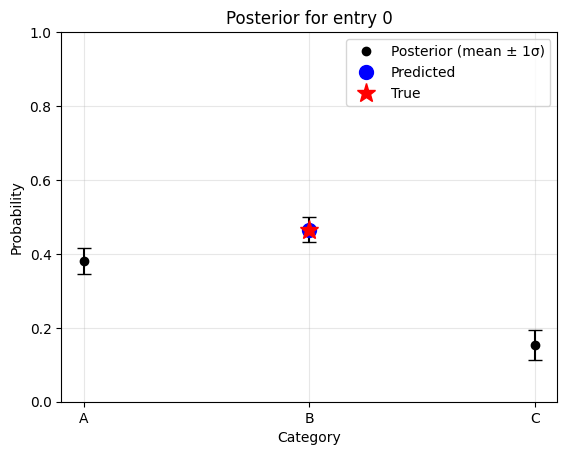

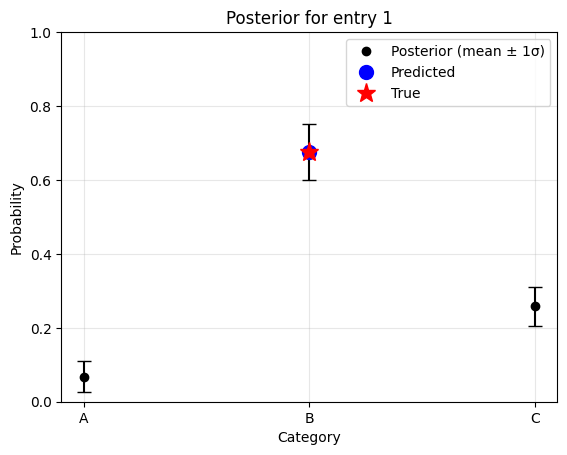

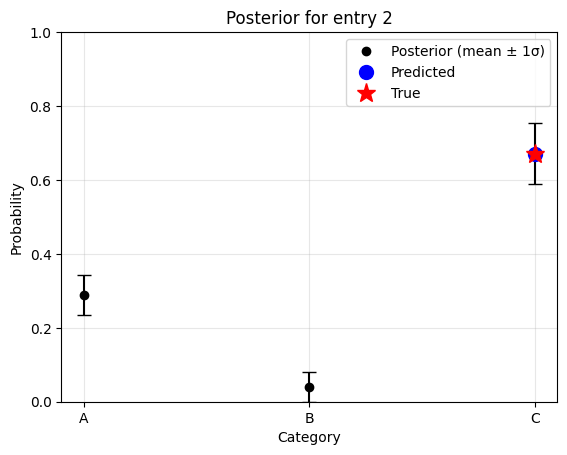

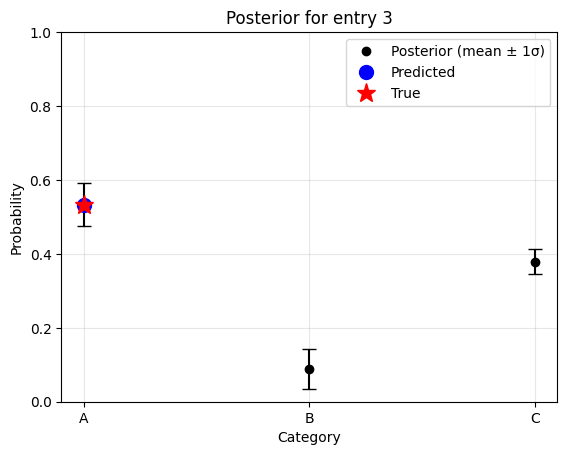

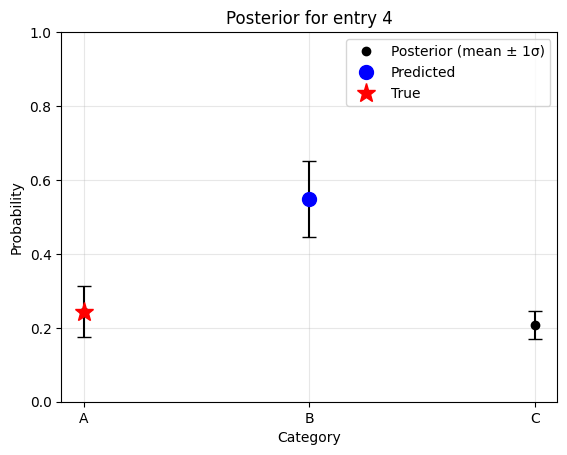

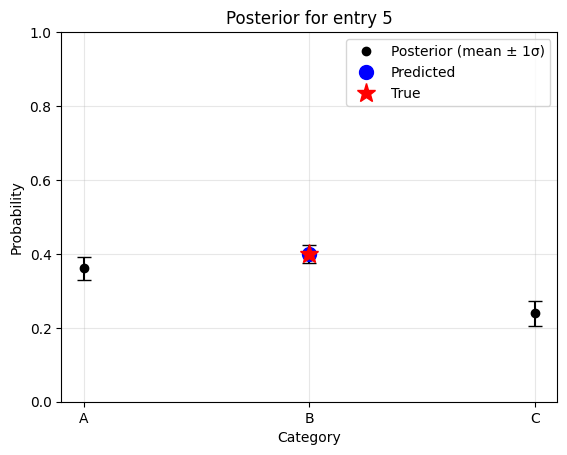

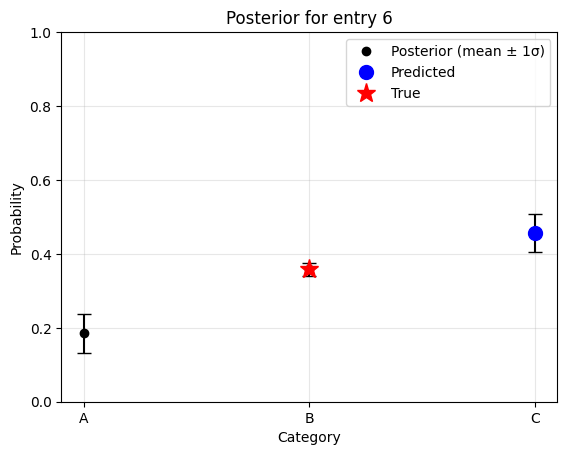

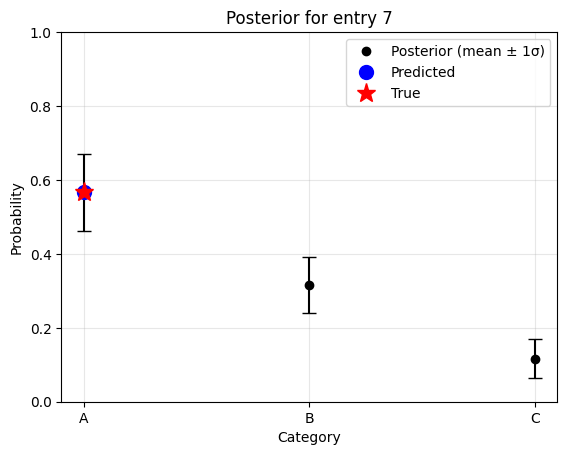

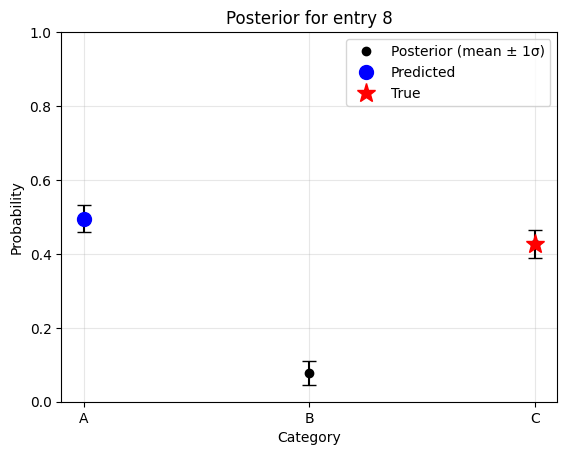

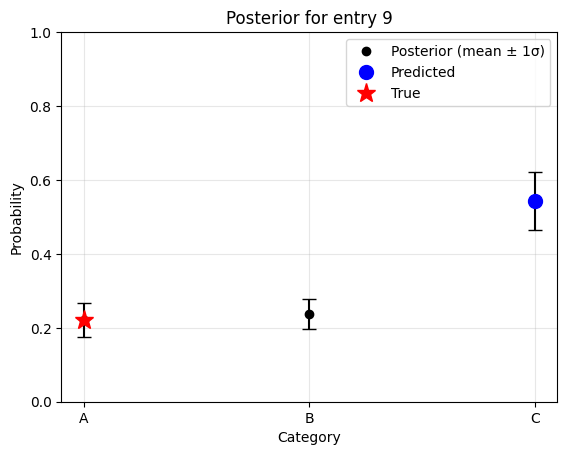

In [316]:
for i in range(min(10, len(P_mean))):
    plot_single_event(P_mean[i], P_std[i], y_true=int(y_te[i]), class_names=["A","B","C"], entry_id=i)


## 10) Notes & Next Steps

- **LoRA targets**: adjust `target_modules` depending on the backbone (e.g., `query`, `key`, `value`, `dense`, or specific module names in RoBERTa/DistilBERT).
- **λ (lam)**: try `0.1, 1.0, 5.0` to see how posterior width affects calibration/abstention.
- **Full Laplace libraries**: for research‑grade Laplace, consider `laplace-torch` (not used here to keep dependencies light).
- **Speed**: keep the model small (`bert-tiny`) and dataset tiny for quick iterations on CPU.
- **Ethical angle**: plot **accuracy vs coverage** and **reliability** to illustrate “knowing when not to answer” after Bayesianizing the LoRA adapters.
